# Download data and models

In [ ]:
# GDRIVE_ID_DATA = "1ONRQ36PFPnYNA4R6ZlmM7UQJ4LiAzEH0"
# !gdown $GDRIVE_ID_DATA -O Arabic-Text-Diacritization.zip
# !unzip Arabic-Text-Diacritization.zip

In [ ]:
# GDRIVE_ID_LSTM_MODEL = "1kLRQ3o7m57qK1OJOTA-K9OBYL29zuXjo"
# !gdown $GDRIVE_ID_LSTM_MODEL -O LSTM.joblib

In [ ]:
# import tarfile

# file_path = "/kaggle/input/tashkeela/Tashkeela-arabic-diacritized-text-utf8-0.3.tar.bz2"
# extract_path = "/kaggle/working/tashkeela_extracted"

# # Extract tar.bz2 file
# with tarfile.open(file_path, "r:bz2") as tar:
#     tar.extractall(path=extract_path)

# extract_path

<h1> Arabic letters and diacritics

In [26]:
import pickle
import re
import pyarabic.araby as araby
import pyarabic.number as number
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import unicodedata
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
import joblib
from sklearn.metrics import accuracy_score
# from arabert import ArabertPreprocessor
# from arabert.aragpt2.grover.modeling_gpt2 import GPT2LMHeadModel

<h2> Constants

In [27]:
window_size = 1000

## GPU Configuration for Kaggle
Check GPU availability and configure TensorFlow to use GPU

In [28]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Get GPU details
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid OOM errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print(f"GPU detected: {gpus}")
        print(f"GPU Name: {tf.test.gpu_device_name()}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Training will use CPU.")

Num GPUs Available:  1
Physical devices cannot be modified after being initialized


## Load Dictionaries and Create Mappings

In [29]:
arabic_letters = []
diacritics = []
diacritics_to_id = {}
with open('./utils/arabic_letters.pickle', 'rb') as f:
    arabic_letters = pickle.load(f)
with open('./utils/diacritics.pickle', 'rb') as f:
    diacritics = pickle.load(f)
with open('./utils/diacritic2id.pickle', 'rb') as f:
    diacritics_to_id = pickle.load(f)

arabic_letters_sorted = sorted(arabic_letters)
char_to_id = {char: idx + 1 for idx, char in enumerate(arabic_letters_sorted)}
char_to_id['<PAD>'] = 0
char_to_id['UNK'] = len(char_to_id)

In [30]:
# Build word vocabulary from training data
def build_word_vocabulary(data):
    """
    Build word vocabulary from training data
    
    Args:
        data: List of text samples
    
    Returns:
        Dictionary mapping words to IDs
    """
    word_counts = {}
    for text in data:
        # Remove diacritics for word tokenization
        text_no_diac = araby.strip_diacritics(text)
        words = araby.tokenize(text_no_diac)
        for word in words:
            if word.strip():  # Skip empty strings
                word_counts[word] = word_counts.get(word, 0) + 1
    
    # Sort by frequency and create word_to_id mapping
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    word_to_id = {'<PAD>': 0, '<UNK>': 1}
    for idx, (word, _) in enumerate(sorted_words):
        word_to_id[word] = idx + 2
    
    return word_to_id

# Will be populated after loading training data
word_to_id = {}

<h2> Read train and val data

In [31]:
train_data = []
val_data = []
with open('./data/train.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        train_data.append(line.strip())
with open('./data/val.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        val_data.append(line.strip())
print(len(train_data))
print(len(val_data))

50000
2500


<h2> Clean data

In [32]:
def clean_arabic_text(text):
    """
    Clean text to keep only Arabic letters, diacritics, and spaces
    """
    # Create a set of allowed characters (Arabic letters + diacritics + space)
    allowed_chars = arabic_letters.union(diacritics, {' ', '\t', '\n'})
    
    # Filter the text to keep only allowed characters
    cleaned_text = ''.join(char for char in text if char in allowed_chars)
    
    # Normalize whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text


def split_sentences(sentences, window_size=window_size):
    all_segments = []
    
    for sentence in sentences:
        words = araby.tokenize(sentence)
        current_segment = []
        current_len = 0
        
        for word in words:
            word_len = len(word)
            add_space = 1 if current_segment else 0
            
            if current_len + word_len + add_space <= window_size:
                current_segment.append(word)
                current_len += word_len + add_space
            else:
                # save the segment
                if current_segment:
                    all_segments.append(" ".join(current_segment))
                
                # start new segment
                current_segment = [word]
                current_len = word_len
        
        # append the final segment of the sentence
        if current_segment:
            all_segments.append(" ".join(current_segment))

    return all_segments



def sentence_tokeniz(sentences):
    tokenized_sentences = []
    for sentence in sentences:
        subsentences = araby.sentence_tokenize(sentence)
        tokenized_sentences.extend(subsentences)
    return tokenized_sentences
        


In [33]:
train_data = sentence_tokeniz(train_data)
val_data = sentence_tokeniz(val_data)

for i in range(len(train_data)):
    train_data[i] = clean_arabic_text(train_data[i])
for i in range(len(val_data)):
    val_data[i] = clean_arabic_text(val_data[i])

train_data = split_sentences(train_data, window_size)
val_data = split_sentences(val_data, window_size)

# Build word vocabulary from training data
print("Building word vocabulary...")
word_to_id = build_word_vocabulary(train_data)
print(f"Word vocabulary size: {len(word_to_id)}")

Building word vocabulary...
Word vocabulary size: 105864


In [34]:
def is_diacritic(ch):
    # Unicode combining marks (Arabic diacritics are combining marks)
    return unicodedata.combining(ch) != 0

def extract_base_and_diacritics(text):
    # normalize to NFC so base+combining marks are consistent
    text = unicodedata.normalize('NFC', text)
    bases = []
    diacs = []
    current_base = None
    current_diac = ''
    for ch in text:
        if is_diacritic(ch):
            # accumulate diacritics for current base
            current_diac += ch
        else:
            # new base character
            if current_base is not None:
                bases.append(current_base)
                diacs.append(current_diac)
            current_base = ch
            current_diac = ''
    # append last
    if current_base is not None:
        bases.append(current_base)
        diacs.append(current_diac)
    return bases, diacs

In [35]:
def extract_char_and_word_features(text, word_to_id):
    """
    Extract both character-level and word-level features from text
    
    Args:
        text: Input text with diacritics
        word_to_id: Dictionary mapping words to IDs
    
    Returns:
        Tuple of (char_ids, diacritic_ids, word_ids, word_positions)
        - char_ids: List of character IDs
        - diacritic_ids: List of diacritic IDs for each character
        - word_ids: List of word IDs aligned with characters
        - word_positions: List indicating position in word (0=start, 1=middle, 2=end, 3=single-char word)
    """
    # Extract base characters and diacritics
    bases, diacs = extract_base_and_diacritics(text)
    
    UNKNOWN_DIACRITIC_ID = diacritics_to_id.get('', len(diacritics_to_id) - 1)

    # Convert characters to IDs
    char_ids = [char_to_id.get(c, char_to_id['UNK']) for c in bases]
    diacritic_ids = [diacritics_to_id.get(d, UNKNOWN_DIACRITIC_ID) for d in diacs]
    
    # Extract word-level features
    text_no_diac = araby.strip_diacritics(text)
    words = araby.tokenize(text_no_diac)
    
    # Create word ID sequence aligned with characters
    word_ids = []
    word_positions = []  # 0=start, 1=middle, 2=end, 3=single-char, 4=space-> # end = 1, any = 0, space = 2
    
    char_idx = 0
    for word in words:
        if not word.strip():
            continue
        
        word_id = word_to_id.get(word, word_to_id['<UNK>'])
        word_len = len(word)
        
        # Assign same word ID to all characters in the word
        for i in range(word_len):
            if char_idx < len(char_ids):
                word_ids.append(word_id)
                
                # Determine position in word
                # if word_len == 1:
                #     word_positions.append(3)  # Single character word
                # elif i == 0:
                #     word_positions.append(0)  # Start of word
                # elif i == word_len - 1:
                #     word_positions.append(2)  # End of word
                # else:
                #     word_positions.append(1)  # Middle of word
                if i == word_len - 1:
                    word_positions.append(1)  # End of word
                else:
                    word_positions.append(0)
                char_idx += 1
        
        # Handle space after word
        if char_idx < len(char_ids) and bases[char_idx] == ' ':
            word_ids.append(0)  # PAD for space
            word_positions.append(2)  # Space position
            char_idx += 1
    
    # Fill remaining with PAD
    while len(word_ids) < len(char_ids):
        word_ids.append(0)
        word_positions.append(2)  # Treat padding as space
    
    return char_ids, diacritic_ids, word_ids, word_positions

<h2> Prepare data for the model

In [36]:
# Prepare training data - extract both character and word level features
x_train_char_raw = []
y_train_raw = []
x_train_word_raw = []
x_train_word_position_raw = []

# Use a constant for unknown diacritic instead of hardcoded value
UNKNOWN_DIACRITIC_ID = diacritics_to_id.get('', len(diacritics_to_id) - 1)

print("Extracting character and word-level features from training data...")
for text in train_data:
    char_ids, diacritic_ids, word_ids, word_positions = extract_char_and_word_features(text, word_to_id)
    
    x_train_char_raw.append(char_ids)
    y_train_raw.append(diacritic_ids)
    x_train_word_raw.append(word_ids)
    x_train_word_position_raw.append(word_positions)

print(f"Training samples: {len(x_train_char_raw)}")

Extracting character and word-level features from training data...
Training samples: 172467


In [37]:
# Pad sequences to same length
PAD_DIACRITIC_ID = diacritics_to_id.get('', 0)  # Use empty string diacritic for padding

x_train_char = tf.keras.preprocessing.sequence.pad_sequences(x_train_char_raw, padding='post', value=0)
x_train_word = tf.keras.preprocessing.sequence.pad_sequences(x_train_word_raw, padding='post', value=0)
x_train_position = tf.keras.preprocessing.sequence.pad_sequences(x_train_word_position_raw, padding='post', value=4)
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train_raw, padding='post', value=PAD_DIACRITIC_ID)

print(f"x_train_char shape: {x_train_char.shape}")
print(f"x_train_word shape: {x_train_word.shape}")
print(f"x_train_position shape: {x_train_position.shape}")
print(f"y_train shape: {y_train.shape}")

x_train_char shape: (172467, 607)
x_train_word shape: (172467, 607)
x_train_position shape: (172467, 607)
y_train shape: (172467, 607)


In [38]:
# Prepare validation data - extract both character and word level features
x_val_char_raw = []
y_val_raw = []
x_val_word_raw = []
x_val_word_position_raw = []

print("Extracting character and word-level features from validation data...")
for text in val_data:
    char_ids, diacritic_ids, word_ids, word_positions = extract_char_and_word_features(text, word_to_id)
    
    x_val_char_raw.append(char_ids)
    y_val_raw.append(diacritic_ids)
    x_val_word_raw.append(word_ids)
    x_val_word_position_raw.append(word_positions)

print(f"Validation samples: {len(x_val_char_raw)}")

Extracting character and word-level features from validation data...
Validation samples: 8332


In [39]:
# Pad validation sequences
x_val_char = tf.keras.preprocessing.sequence.pad_sequences(x_val_char_raw, padding='post', value=0)
x_val_word = tf.keras.preprocessing.sequence.pad_sequences(x_val_word_raw, padding='post', value=0)
x_val_position = tf.keras.preprocessing.sequence.pad_sequences(x_val_word_position_raw, padding='post', value=4)
y_val = tf.keras.preprocessing.sequence.pad_sequences(y_val_raw, padding='post', value=PAD_DIACRITIC_ID)

print(f"x_val_char shape: {x_val_char.shape}")
print(f"x_val_word shape: {x_val_word.shape}")
print(f"x_val_position shape: {x_val_position.shape}")
print(f"y_val shape: {y_val.shape}")

x_val_char shape: (8332, 597)
x_val_word shape: (8332, 597)
x_val_position shape: (8332, 597)
y_val shape: (8332, 597)


In [40]:
class DERMetric(tf.keras.metrics.Metric):
    def __init__(self, pad_id=0, space_id=None, name='DER', **kwargs):
        super(DERMetric, self).__init__(name=name, **kwargs)
        self.pad_id = pad_id
        self.space_id = space_id
        self.total = self.add_weight(name='total', initializer='zeros')
        self.errors = self.add_weight(name='errors', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        y_true: shape (batch_size, seq_len)
        y_pred: shape (batch_size, seq_len, num_classes)
        """
        # Get predicted labels
        y_pred_labels = tf.argmax(y_pred, axis=-1, output_type=tf.int32)

        # Create mask for valid positions (not padding)
        mask = tf.not_equal(y_true, self.pad_id)
        if self.space_id is not None:
            mask = tf.logical_and(mask, tf.not_equal(y_true, self.space_id))

        # Compare predictions to ground truth
        correct = tf.equal(y_true, y_pred_labels)
        correct = tf.logical_and(correct, mask)

        # Count errors and total valid positions
        batch_errors = tf.reduce_sum(tf.cast(~correct, tf.float32))
        batch_total = tf.reduce_sum(tf.cast(mask, tf.float32))

        # Update state
        self.errors.assign_add(batch_errors)
        self.total.assign_add(batch_total)

    def result(self):
        return (self.errors / self.total) * 100  # DER in %

    def reset_state(self):
        self.errors.assign(0)
        self.total.assign(0)


In [41]:
# vocab sizes (your variables)
vocab_size = len(char_to_id)
num_diacritics = len(diacritics_to_id)
word_vocab_size = len(word_to_id)

# ==============================
# 1. CHARACTER INPUT
# ==============================
char_input = Input(shape=(None,), name='char_input')
char_embedding = layers.Embedding(
    input_dim=vocab_size,
    output_dim=128,
    mask_zero=True,
    name='char_embedding'
)(char_input)

# ==============================
# 2. WORD INPUT
# ==============================
word_input = Input(shape=(None,), name='word_input')
word_embedding = layers.Embedding(
    input_dim=word_vocab_size,
    output_dim=128,
    mask_zero=True,
    name='word_embedding'
)(word_input)

# ==============================
# 3. WORD POSITION INPUT (0=start, 1=middle, 2=end, 3=single-char, 4=space)
# ==============================
position_input = Input(shape=(None,), name='position_input')
position_embedding = layers.Embedding(
    input_dim=3,  # 3 position types
    output_dim=16,
    mask_zero=False,
    name='position_embedding'
)(position_input)

# ==============================
# 4. CONCATENATE FEATURES
# ==============================
combined = layers.Concatenate(name='feature_concat')([
    char_embedding,
    word_embedding,
    position_embedding
])

# IMPORTANT FIX: Use only char mask to avoid GPU mask mismatch
combined._keras_mask = char_embedding._keras_mask

# ==============================
# 5. BiLSTM FOR DIACRITIZATION
# ==============================
lstm_out = layers.Bidirectional(
    layers.LSTM(
        256,
        return_sequences=True,
        activation='tanh',
        recurrent_activation='sigmoid'
    ),
    name='bilstm'
)(combined)

# ==============================
# 6. OUTPUT LAYER
# ==============================
output = layers.Dense(
    num_diacritics,
    activation='softmax',
    name='diacritic_output'
)(lstm_out)

# ==============================
# 7. CREATE & COMPILE MODEL
# ==============================
model = Model(
    inputs=[char_input, word_input, position_input],
    outputs=output
)

der_metric = DERMetric(pad_id=0, space_id=char_to_id["<PAD>"])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=[der_metric]
)

print("\nModel Architecture:")
print("Position encoding: 0=start, 1=middle, 2=end, 3=single-char, 4=space")
model.summary()



Model Architecture:
Position encoding: 0=start, 1=middle, 2=end, 3=single-char, 4=space


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_input          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_input      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embedding      │ (None, None, 128) │      4,864 │ char_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, None, 128) │ 13,550,592 │ word_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 16)  │         48 │ position_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_concat      │ (None, None, 272) │          0 │ char_embedding[0… │
│ (Concatenate)       │                   │            │ word_embedding[0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, None)      │          0 │ char_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, None, 512) │  1,083,392 │ feature_concat[0… │
│ (Bidirectional)     │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diacritic_output    │ (None, None, 15)  │      7,695 │ bilstm[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,646,591 (55.87 MB)

 Trainable params: 14,646,591 (55.87 MB)

 Non-trainable params: 0 (0.00 B)

## Class Imbalance Analysis

In [42]:
# Analyze class distribution in training data
from collections import Counter

# Flatten y_train and count occurrences
y_train_flat = y_train.flatten()
diacritic_counts = Counter(y_train_flat)

# Sort by diacritic ID
id_to_diacritic = {v: k for k, v in diacritics_to_id.items()}

print("Diacritic Class Distribution:")
print("="*60)
total_diacritics = len(y_train_flat)

for diac_id in sorted(diacritic_counts.keys()):
    count = diacritic_counts[diac_id]
    percentage = (count / total_diacritics) * 100
    diac_symbol = id_to_diacritic.get(diac_id, 'UNKNOWN')
    diac_display = diac_symbol if diac_symbol else '<NO_DIACRITIC>'
    print(f"ID {diac_id:2d} ({diac_display:15s}): {count:8d} ({percentage:5.2f}%)")

print("="*60)
print(f"Total: {total_diacritics:,}")

# Calculate class imbalance ratio
max_count = max(diacritic_counts.values())
min_count = min(v for k, v in diacritic_counts.items() if k != PAD_DIACRITIC_ID)
imbalance_ratio = max_count / min_count
print(f"\nClass Imbalance Ratio (max/min): {imbalance_ratio:.2f}:1")

Diacritic Class Distribution:
ID  0 (َ              ):  2932361 ( 2.80%)
ID  1 (ً              ):    58104 ( 0.06%)
ID  2 (ُ              ):   811590 ( 0.78%)
ID  3 (ٌ              ):    58115 ( 0.06%)
ID  4 (ِ              ):  1264779 ( 1.21%)
ID  5 (ٍ              ):    87730 ( 0.08%)
ID  6 (ْ              ):  1229871 ( 1.17%)
ID  7 (ّ              ):     6240 ( 0.01%)
ID 14 (<NO_DIACRITIC> ): 98238679 (93.84%)
Total: 104,687,469

Class Imbalance Ratio (max/min): 15743.38:1


In [43]:
# Optional: Calculate class weights for handling imbalance
# Exclude padding from weight calculation
from sklearn.utils.class_weight import compute_class_weight

# Get unique classes excluding padding
unique_classes = [c for c in np.unique(y_train_flat) if c != PAD_DIACRITIC_ID]

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_flat[y_train_flat != PAD_DIACRITIC_ID]
)

# Create class weight dictionary
class_weights = {class_id: weight for class_id, weight in zip(unique_classes, class_weights_array)}
# Add padding with weight 0 (ignore padding in loss)
class_weights[PAD_DIACRITIC_ID] = 0.0

print("\nClass Weights (for balanced training):")
print("="*60)
for diac_id in sorted(class_weights.keys()):
    diac_symbol = id_to_diacritic.get(diac_id, 'UNKNOWN')
    diac_display = diac_symbol if diac_symbol else '<NO_DIACRITIC>'
    print(f"ID {diac_id:2d} ({diac_display:15s}): {class_weights[diac_id]:.4f}")
print("="*60)


Class Weights (for balanced training):
ID  0 (َ              ): 0.2749
ID  1 (ً              ): 13.8734
ID  2 (ُ              ): 0.9932
ID  3 (ٌ              ): 13.8708
ID  4 (ِ              ): 0.6373
ID  5 (ٍ              ): 9.1884
ID  6 (ْ              ): 0.6554
ID  7 (ّ              ): 129.1825
ID 14 (<NO_DIACRITIC> ): 0.0000


## Setup Callbacks for Training
Configure early stopping and model checkpointing

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

# Create directory for saving models if it doesn't exist
model_save_dir = "./models"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# Early Stopping: Stop training when validation DER stops improving
early_stopping = EarlyStopping(
    monitor='val_DER',           # Monitor validation DER
    patience=3,                  # Number of epochs with no improvement after which training will be stopped
    mode='min',                  # Lower DER is better
    verbose=1,
    restore_best_weights=True    # Restore model weights from the epoch with best value
)

# Model Checkpoint: Save the best model during training
checkpoint_path = os.path.join(model_save_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_DER',           # Monitor validation DER
    mode='min',                  # Lower DER is better
    save_best_only=True,         # Only save when val_DER improves
    verbose=1
)

# Learning Rate Reduction: Reduce learning rate when validation DER plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_DER',
    factor=0.5,                  # Reduce LR by half
    patience=2,                  # Reduce LR after 2 epochs of no improvement
    mode='min',
    verbose=1,
    min_lr=1e-7                  # Minimum learning rate
)

# Combine all callbacks
callbacks = [early_stopping, model_checkpoint, reduce_lr]

print("Callbacks configured:")
print(f"✓ Early Stopping (patience=3, monitor=val_DER)")
print(f"✓ Model Checkpoint (save to: {checkpoint_path})")
print(f"✓ Reduce Learning Rate on Plateau (factor=0.5, patience=2)")

Callbacks configured:
✓ Early Stopping (patience=3, monitor=val_DER)
✓ Model Checkpoint (save to: ./models/best_model.keras)
✓ Reduce Learning Rate on Plateau (factor=0.5, patience=2)


## Train Model with Validation and Callbacks

In [ ]:
# Train model with multi-input (character + word features)
# Now includes validation data, callbacks, and optional class weights
with tf.device('/GPU:0'):
    history = model.fit(
        {'char_input': x_train_char, 'word_input': x_train_word, 'position_input': x_train_position},
        y_train,
        validation_data=(
            {'char_input': x_val_char, 'word_input': x_val_word, 'position_input': x_val_position},
            y_val
        ),
        epochs=50,                    # Increased epochs; early stopping will halt if needed
        batch_size=64,
        callbacks=callbacks,
        # class_weight=class_weights, # Uncomment to use class weights for imbalanced data
        verbose=1
    )

## Training History Visualization

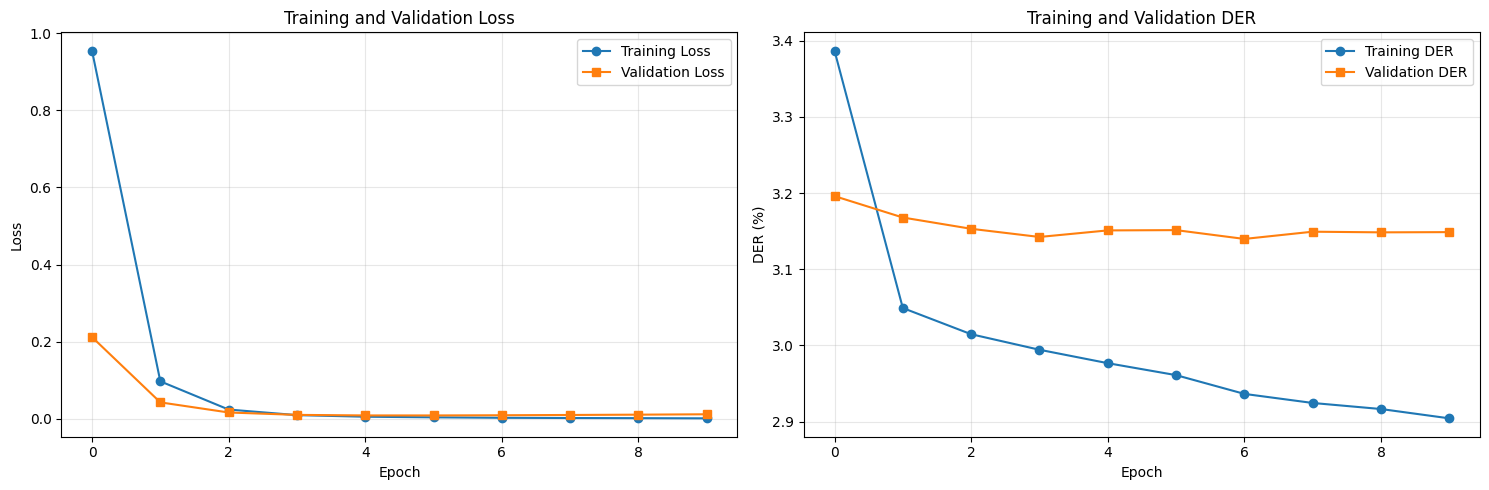


Training Summary:
Best Epoch: 7
Best Validation DER: 3.14%
Best Validation Loss: 0.0090
Total Epochs Trained: 10


In [46]:
import matplotlib.pyplot as plt

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(history.history['loss'], label='Training Loss', marker='o')
axes[0].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot DER
axes[1].plot(history.history['DER'], label='Training DER', marker='o')
axes[1].plot(history.history['val_DER'], label='Validation DER', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('DER (%)')
axes[1].set_title('Training and Validation DER')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best epoch info
best_epoch = np.argmin(history.history['val_DER'])
print("\n" + "="*60)
print("Training Summary:")
print("="*60)
print(f"Best Epoch: {best_epoch + 1}")
print(f"Best Validation DER: {history.history['val_DER'][best_epoch]:.2f}%")
print(f"Best Validation Loss: {history.history['val_loss'][best_epoch]:.4f}")
print(f"Total Epochs Trained: {len(history.history['loss'])}")
print("="*60)

## Load Best Model 
Load the best model saved during training locally

In [51]:
# Load the best model saved by ModelCheckpoint
# Note: With restore_best_weights=True in EarlyStopping, the model variable already has the best weights
# But we can also load from file if needed

# Option 1: Current model already has best weights (due to early stopping restore_best_weights=True)
print("Current model has best weights restored by EarlyStopping")

# Option 2: Load from saved checkpoint file
from tensorflow.keras.models import load_model
model = load_model(checkpoint_path, custom_objects={'DERMetric': DERMetric})
print(f"Model loaded from: {checkpoint_path}")

Current model has best weights restored by EarlyStopping
Model loaded from: ./models/best_model.keras


In [ ]:
# joblib.dump(model, "/kaggle/working/LSTM2.joblib")

In [ ]:
# model = joblib.load("./models/LSTM.joblib")

## Load model from Huggingface Repo

In [ ]:
from huggingface_hub import hf_hub_download
from tensorflow.keras.models import load_model

repo_id = "OmarMoh11/ArabicDiacritizer"

filepath = hf_hub_download(repo_id=repo_id, filename="best_model.keras")
model = load_model(filepath)

<h2> Test Val</h2>

In [52]:
y_pred = model.predict({'char_input': x_val_char, 'word_input': x_val_word, 'position_input': x_val_position})

261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


In [53]:
def calculate_der_by_position(x_val_char, y_true, y_pred, char_to_id):
    """
    Calculate DER separately for last characters and non-last characters in words
    
    Args:
        x_val_char: Character sequences (samples × sequence_length)
        y_true: Ground truth diacritic labels (samples × sequence_length)
        y_pred: Predicted diacritic labels (samples × sequence_length)
        char_to_id: Dictionary mapping characters to IDs
    
    Returns:
        Tuple of (DER_non_last, DER_last, overall_DER)
    """
    # Get space character ID
    space_id = char_to_id.get(' ', char_to_id.get('UNK'))
    pad_id = char_to_id.get('<PAD>', 0)
    
    non_last_errors = 0
    non_last_total = 0
    last_errors = 0
    last_total = 0
    
    # Process each sequence
    for char_seq, y_true_seq, y_pred_seq in zip(x_val_char, y_true, y_pred):
        # Find valid (non-padding) characters
        valid_mask = char_seq != pad_id
        valid_indices = np.where(valid_mask)[0]
        
        if len(valid_indices) == 0:
            continue
        
        # Identify word boundaries (spaces and end of sequence)
        i = 0
        while i < len(valid_indices):
            idx = valid_indices[i]
            
            # Skip spaces
            if char_seq[idx] == space_id:
                i += 1
                continue
            
            # Find the end of current word
            word_start = i
            while i < len(valid_indices) and char_seq[valid_indices[i]] != space_id:
                i += 1
            word_end = i - 1
            
            # Mark positions in the word
            for j in range(word_start, word_end + 1):
                pos_idx = valid_indices[j]
                
                # Skip if this position has padding in y_true
                if y_true_seq[pos_idx] == PAD_DIACRITIC_ID:
                    continue
                
                is_correct = (y_true_seq[pos_idx] == y_pred_seq[pos_idx])
                
                # Last character in word
                if j == word_end:
                    last_total += 1
                    if not is_correct:
                        last_errors += 1
                # Non-last character in word
                else:
                    non_last_total += 1
                    if not is_correct:
                        non_last_errors += 1
    
    # Calculate DER for each category
    der_non_last = (non_last_errors / non_last_total * 100) if non_last_total > 0 else 0
    der_last = (last_errors / last_total * 100) if last_total > 0 else 0
    
    total_errors = non_last_errors + last_errors
    total_chars = non_last_total + last_total
    der_overall = (total_errors / total_chars * 100) if total_chars > 0 else 0
    
    return der_non_last, der_last, der_overall

In [54]:
y_pred_classes = np.argmax(y_pred, axis=-1)
y_true = y_val

# Calculate accuracy
accuracy = accuracy_score(y_true.flatten(), y_pred_classes.flatten())
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.9976


In [55]:
# Calculate DER by character position in words
der_non_last, der_last, der_overall = calculate_der_by_position(x_val_char, y_true, y_pred_classes, char_to_id)

print("\n" + "="*60)
print("DER Analysis by Character Position in Words")
print("="*60)
print(f"DER for non-last characters: {der_non_last:.2f}%")
print(f"DER for last characters:     {der_last:.2f}%")
print(f"Overall DER:                 {der_overall:.2f}%")
print(f"\nAccuracy for non-last characters: {100 - der_non_last:.2f}%")
print(f"Accuracy for last characters:     {100 - der_last:.2f}%")
print(f"Acutual Accuracy: {100 - der_overall:.2f}%")
print("="*60)


DER Analysis by Character Position in Words
DER for non-last characters: 2.86%
DER for last characters:     5.39%
Overall DER:                 3.47%

Accuracy for non-last characters: 97.14%
Accuracy for last characters:     94.61%
Acutual Accuracy: 96.53%


<h2> Uploal model on Hugging Face.

In [57]:
from huggingface_hub import login, upload_folder, create_repo

# # Step 1: Login
# login()

# Step 2: Repo info
repo_id = "OmarMoh11/ArabicDiacritizer"

# Step 3: Create repo if not exists
create_repo(repo_id, private=False, exist_ok=True)

# # Step 4: Save model locally
# model.save("model_export/best_model.keras")

# Step 5: Add metadata and README
with open("models/README.md", "w", encoding="utf-8") as f:
    f.write("# Arabic Diacritization Model\nThis is a multi-input Keras model.")

with open("models/config.json", "w", encoding="utf-8") as f:
    f.write('{"model_type": "keras", "description": "Arabic diacritization model"}')

# Step 6: Upload folder
upload_folder(
    repo_id=repo_id,
    folder_path="models",
    commit_message="Upload diacritization model v1"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9662: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/OmarMoh11/ArabicDiacritizer/commit/f8c6ad0a48f2d086a52d5c44843bd2ae06d01814', commit_message='Upload diacritization model v1', commit_description='', oid='f8c6ad0a48f2d086a52d5c44843bd2ae06d01814', pr_url=None, repo_url=RepoUrl('https://huggingface.co/OmarMoh11/ArabicDiacritizer', endpoint='https://huggingface.co', repo_type='model', repo_id='OmarMoh11/ArabicDiacritizer'), pr_revision=None, pr_num=None)

<h2> Test data

In [ ]:
def merge(x_test, y_pred_classes, char_to_id, diacritics_to_id):
    """
    Merge character sequences with predicted diacritics to reconstruct text
    
    Args:
        x_test: numpy array of character IDs (samples × sequence_length)
        y_pred_classes: numpy array of predicted diacritic IDs (samples × sequence_length)
        char_to_id: dictionary mapping characters to IDs
        diacritics_to_id: dictionary mapping diacritics to IDs
    
    Returns:
        List of reconstructed diacritized text strings
    """
    # Create reverse mappings
    id_to_char = {v: k for k, v in char_to_id.items()}
    id_to_diacritic = {v: k for k, v in diacritics_to_id.items()}
    
    reconstructed_texts = []
    
    # Process each sample
    for char_seq, diac_seq in zip(x_test, y_pred_classes):
        text = ""
        
        for char_id, diac_id in zip(char_seq, diac_seq):
            # Skip padding
            if char_id == 0:  # PAD character
                break
            
            # Get character
            char = id_to_char.get(char_id, '')
            
            # Get diacritic
            diacritic = id_to_diacritic.get(diac_id, '')
            
            # Combine character with diacritic
            text += char + diacritic
        
        text = text.replace("UNK", " ")
        reconstructed_texts.append(text)
    
    return reconstructed_texts

In [ ]:
def test_model_with_word_features(text, word_to_id):
    """
    Prepare test text for prediction with word-level features
    
    Args:
        text: Input text without diacritics
        word_to_id: Dictionary mapping words to IDs
    
    Returns:
        Tuple of (char_ids, word_ids, word_positions) padded and ready for prediction
    """
    # Strip diacritics if present
    text_clean = araby.strip_diacritics(text)
    
    # Get characters
    char_ids = [char_to_id.get(c, char_to_id['UNK']) for c in text_clean]
    
    # Get words
    words = araby.tokenize(text_clean)
    
    # Create word ID sequence aligned with characters
    word_ids = []
    word_positions = []  # 0=start, 1=middle, 2=end, 3=single-char, 4=space
    
    char_idx = 0
    for word in words:
        if not word.strip():
            continue
        
        word_id = word_to_id.get(word, word_to_id['<UNK>'])
        word_len = len(word)
        
        for i in range(word_len):
            if char_idx < len(char_ids):
                word_ids.append(word_id)
                
                # Determine position in word
                if word_len == 1:
                    word_positions.append(3)  # Single character word
                elif i == 0:
                    word_positions.append(0)  # Start of word
                elif i == word_len - 1:
                    word_positions.append(2)  # End of word
                else:
                    word_positions.append(1)  # Middle of word
                
                char_idx += 1
        
        # Handle space
        if char_idx < len(char_ids) and text_clean[char_idx] == ' ':
            word_ids.append(0)
            word_positions.append(4)  # Space position
            char_idx += 1
    
    # Fill remaining
    while len(word_ids) < len(char_ids):
        word_ids.append(0)
        word_positions.append(4)
    
    # Pad to model expected shape (add batch dimension)
    char_ids_padded = tf.keras.preprocessing.sequence.pad_sequences([char_ids], padding='post', value=0)
    word_ids_padded = tf.keras.preprocessing.sequence.pad_sequences([word_ids], padding='post', value=0)
    positions_padded = tf.keras.preprocessing.sequence.pad_sequences([word_positions], padding='post', value=4)
    
    return char_ids_padded, word_ids_padded, positions_padded

In [ ]:
test_sent = "هذا نص تجريبي لاختبار نموذج تشكيل النص العربي"

x_test_char, x_test_word, x_test_position = test_model_with_word_features(test_sent, word_to_id)
y_test_pred = model.predict({
    'char_input': x_test_char, 
    'word_input': x_test_word, 
    'position_input': x_test_position
})
y_test_pred_classes = np.argmax(y_test_pred, axis=-1)

In [ ]:
y_test_pred.shape

In [ ]:
output_sentences = merge(x_test_char, y_test_pred_classes, char_to_id, diacritics_to_id)[0]
print("Input text:", test_sent)
print("Diacritized output:", output_sentences)